# When is Multicollinearity an Issue?

> Multicollinearity can be an issue in multiple regression, however, just because some multicollinearity exists does not imply it is causing an issue in a particular regression.

In [ ]:
#| default_export multicollinearity

In [ ]:
#| hide
from nbdev.showdoc import *
import pprint
from itertools import product
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pymc as pm
from tueplots import bundles
from tueplots.constants.color import rgb
import seaborn as sns
import graphviz as gviz
from common_regression_issues.utils.plotting import rgb_to_hex

In [ ]:
#| hide
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#| hide
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

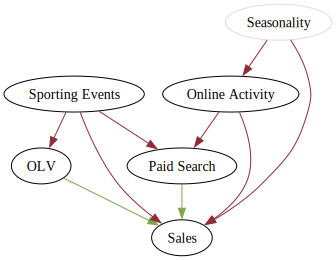

In [ ]:
#| echo: false
#| label: fig-causal-graph
#| fig-cap: Causal Graph
GRAY = rgb_to_hex(rgb.mps_gray*255)
RED = rgb_to_hex(rgb.tue_red*255)
GREEN = rgb_to_hex(rgb.tue_green*255)
g = gviz.Digraph()
g.node("var_0", "Paid Search")
g.node("var_1", "OLV")
g.node("con_0", "Online Activity")
g.node("con_1", "Sporting Events")
g.node("depvar", "Sales")
g.node("Seasonality", color=GRAY)
g.edge("var_0", 'depvar', color=GREEN)
g.edge("var_1", 'depvar', color=GREEN)
g.edge("con_0", "var_0", color=RED)
g.edge("con_0", 'depvar', color=RED)
#g.edge("con_0", "var_1", color=RED)
g.edge("con_1", 'var_1', color=RED)
g.edge("con_1", "var_0", color=RED)
g.edge("con_1", "depvar", color=RED)
g.edge("Seasonality", "depvar", color=RED)
g.edge("Seasonality", "con_0", color=RED)
g

See @fig-causal-graph